In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [13]:
!ls "/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints"

'4. Fun with Keypoints.ipynb'   images	    moi.jpg	       saved_models
 data			        LICENSE     __pycache__        test2.jpg
 detector_architectures         models.py   README.md
 Facial_keypoints.ipynb         moi2.jpg    requirements.txt


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models
import torch.optim as optim

#### Create dataset

In [0]:
batch_size = 128 #128 in the paper but collab run out of memory
num_workers = 4
csv_file = '/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/data/training_frames_keypoints.csv'
root_dir = '/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/data/training/'

transform = transforms.Compose([
    Rescale(256),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])

train_set = FacialKeypointsDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

#### Prepare Validation set and Load data

In [0]:
def train_valid_split(training_set, validation_size):
    """ Function that split our dataset into train and validation
        given in parameter the training set and the % of sample for validation"""
    
    # obtain training indices that will be used for validation
    num_train = len(training_set)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(validation_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    return train_sampler, valid_sampler


valid_size = 0.3
train_sampler, valid_sampler = train_valid_split(train_set, valid_size)


train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                          num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers)

#### Visualize

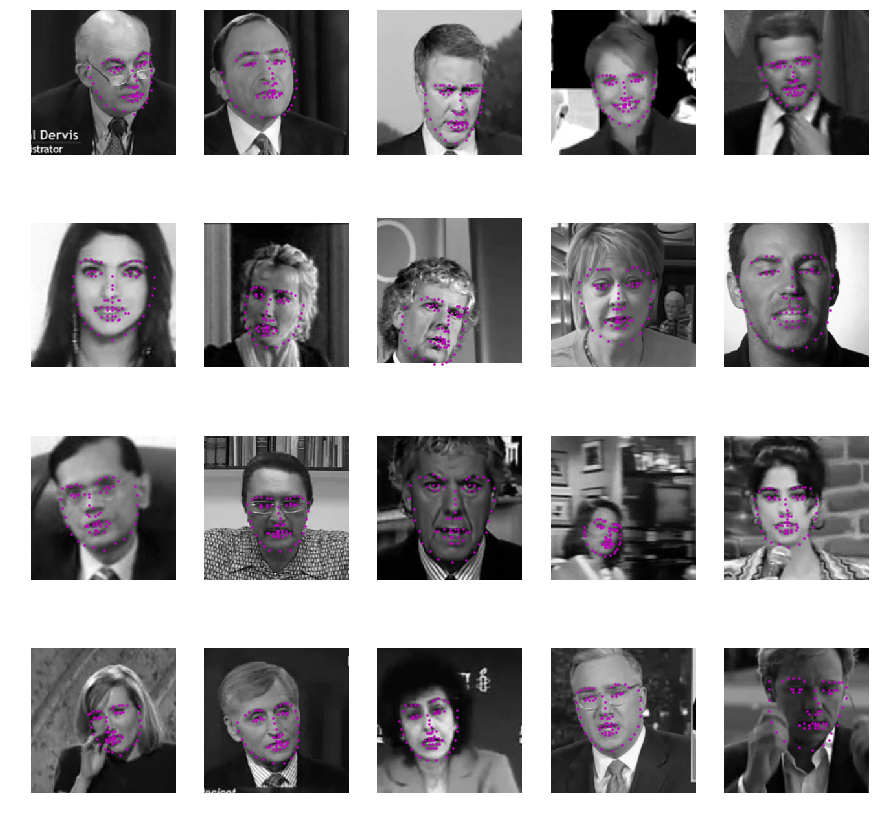

In [24]:
plt.figure(figsize=(15,15))

# obtain one batch of training images
batch = next(iter(train_loader))

# display 20 images
for i in np.arange(20):
    
    images, labels = batch['image'], batch['keypoints']
    
    #unormalize images
    image = images[i].numpy()
    image = np.transpose(image, (1, 2, 0))
     
    #unormalize labels
    labels = labels[i].numpy()
    labels = labels*50.0+100
    
    plt.subplot(4,5,i+1)
    plt.imshow(np.squeeze(image), cmap='gray')
    plt.scatter(labels[:, 0], labels[:, 1], s=20, marker='.', c='m')
    plt.axis('off')

In [26]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA not available... Training on CPU')
else:
    print('CUDA available... Training on GPU')

CUDA available... Training on GPU


In [27]:
model = Net()

print(f"input features: {model.fc1.in_features}") 
print(f"output features: {model.fc3.out_features}")

input features: 43264
output features: 136


In [0]:
if train_on_gpu:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001, betas=(0.9, 0.999), eps=1e-08)

#### Train

In [ ]:
n_epochs = 300

valid_loss_min = np.Inf

model.train()

for epoch in range(1, n_epochs+1):

    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    for data in train_loader:
        
        # Grab the image and its corresponding label
        images = data['image']
        key_pts = data['keypoints']
      
        if train_on_gpu:
            images, key_pts = images.cuda(), key_pts.cuda()
        
        
        # Flatten keypoints & convert data to FloatTensor for regression loss
        key_pts = key_pts.view(key_pts.size(0), -1)
        key_pts = key_pts.type(torch.cuda.FloatTensor)
        images = images.type(torch.cuda.FloatTensor)
                  
        
        optimizer.zero_grad()                           # Clear the gradient        
        output = model(images)                          # Forward
        loss = criterion(output, key_pts)               # Compute the loss
        loss.backward()                                 # Compute the gradient
        optimizer.step()                                # Perform updates using calculated gradients
        
        train_loss += loss.item()*images.size(0)




    # Validation
    model.eval()
    for data in valid_loader:
        
        images = data['image']
        key_pts = data['keypoints']

        if train_on_gpu:
            images, key_pts = images.cuda(), key_pts.cuda()
        
        
        key_pts = key_pts.view(key_pts.size(0), -1)
        key_pts = key_pts.type(torch.cuda.FloatTensor)
        images = images.type(torch.cuda.FloatTensor)
        
        output = model(images)
        loss = criterion(output, key_pts)
        
        valid_loss += loss.item()*images.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # print training/validation statistics 
    print(f"Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}")

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...")
        torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/saved_models/model2_128_bs.pt')
        valid_loss_min = valid_loss